In [1]:
from dotenv import load_dotenv

load_dotenv()

True

#### Ejecuciones en paralelo

In [2]:
import operator
import os
from typing import Annotated

import requests
from langchain_anthropic import ChatAnthropic  # noqa
from langchain_ollama import ChatOllama  # noqa
from pydantic import BaseModel
from typing_extensions import TypedDict

from langgraph.graph import END, START, StateGraph
from langgraph.types import Send

In [ ]:
cities_prompt = (
    """Identifica las ciudades y genera una lista separada por coma {cities}."""
)

model_prompt = """
    Compara lo datos de la temperatura, humedad y viento de las ciudades: 
    
    {weathers}
    
    y genera un breve resumen de las condiciones climáticas y la vestimenta adecuada para el día.
    """

In [ ]:
class Cities(BaseModel):
    cities: list[str]


class Weather(BaseModel):
    weather: str

In [ ]:
model = ChatAnthropic(model_name="claude-3-haiku-20240307", temperature=0)
# model = ChatOllama(model="llama3.1:latest", temperature=0)

In [ ]:
class OverallState(TypedDict):
    cities: str
    message: str
    weathers: Annotated[list, operator.add]


class WeathersState(TypedDict):
    city: str

In [3]:
def get_cities(state: OverallState):
    prompt = cities_prompt.format(cities=state["cities"])
    response = model.with_structured_output(Cities).invoke(prompt)
    return {"cities": response.cities}

def generate_weather(state: WeathersState):
    city = state["city"]
    WEATHER_API_KEY = os.getenv("WEATHER_API_KEY")

    resp = requests.get(
        f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{city}/today?unitGroup=metric&include=current&key={WEATHER_API_KEY}&contentType=json"
    )
    data = resp.json()

    return {"weathers": [data]}

def continue_to_action(state: OverallState):
    return [Send("generate_weather", {"city": c}) for c in state["cities"]]


def model_response(state: OverallState):
    weathers = state["weathers"]
    prompt = model_prompt.format(weathers=weathers)
    response = model.invoke(prompt)
    
    return {"message": [response.content]}

In [ ]:
workflow = StateGraph(OverallState)

workflow.add_node("get_cities", get_cities)
workflow.add_node("generate_weather", generate_weather)
workflow.add_node("model_response", model_response)

workflow.add_edge(START, "get_cities")
workflow.add_conditional_edges("get_cities", continue_to_action, ["generate_weather"])
workflow.add_edge("generate_weather", "model_response")
workflow.add_edge("model_response", END)

graph = workflow.compile()

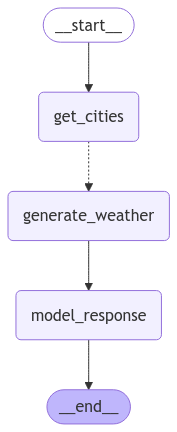

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


#### Prueba

In [5]:
for s in graph.stream({
    "cities": "las ciudades son santiago de chile, san francisco y tokio"
}):
    print(s)

{'get_cities': {'cities': ['Santiago de Chile', 'San Francisco', 'Tokyo']}}
{'generate_weather': {'weathers': [{'queryCost': 1, 'latitude': 37.7771, 'longitude': -122.42, 'resolvedAddress': 'San Francisco, CA, United States', 'address': 'San Francisco', 'timezone': 'America/Los_Angeles', 'tzoffset': -8.0, 'days': [{'datetime': '2025-01-27', 'datetimeEpoch': 1737964800, 'tempmax': 15.2, 'tempmin': 3.1, 'temp': 9.2, 'feelslikemax': 15.2, 'feelslikemin': 1.8, 'feelslike': 8.9, 'dew': 1.3, 'humidity': 59.4, 'precip': 0.0, 'precipprob': 1.0, 'precipcover': 0.0, 'preciptype': None, 'snow': 0.0, 'snowdepth': 0.0, 'windgust': 13.0, 'windspeed': 15.4, 'winddir': 260.5, 'pressure': 1020.8, 'cloudcover': 1.2, 'visibility': 17.9, 'solarradiation': 156.0, 'solarenergy': 13.5, 'uvindex': 6.0, 'severerisk': 10.0, 'sunrise': '07:17:22', 'sunriseEpoch': 1737991042, 'sunset': '17:28:14', 'sunsetEpoch': 1738027694, 'moonphase': 0.95, 'conditions': 'Clear', 'description': 'Clear conditions throughout the 